In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
quote = Quote(screen_funds('Industries'), 75, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

from 2019-04-24 to 2019-07-08 - 62


In [4]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats

44


,len,mean,std,shrp,drawdown
Symbols,,,,,
GDX,47,2.102832,4.276041,0.482491,6.075660
XAR,47,0.852297,1.708253,0.475699,2.579733
IHI,47,0.984827,2.056317,0.459630,4.510425
IXJ,47,0.660817,1.636760,0.379490,3.337207
GDXJ,47,1.770346,4.701096,0.368140,6.657301
XLV,47,0.657657,1.802572,0.342829,3.729859
FHLC,47,0.643637,1.804517,0.334691,4.334999
IGF,47,0.500616,1.389907,0.331629,2.242252
VHT,47,0.638949,1.831326,0.327231,4.345281


evicted IGF 0.820112837817546
evicted EMLP 0.8249759660823365
evicted FXU 0.8577321027826952
evicted GNR 0.8183889234558945
evicted XLU 0.6951367763787836
evicted RYT 0.8884093122581276
evicted IGV 0.8449818574305027
evicted XLY 0.83249387544894
evicted XLP 0.7197397589492531
evicted XLB 0.738642520659283
evicted XLF 0.7745259118606675
evicted ARKK 0.7775193427673622
evicted ITB 0.6023509034857606
evicted XBI 0.5966632754951123
retry backlogs ['VPU', 'VGT', 'IYH', 'VHT', 'VDC', 'VFH', 'FHLC', 'VAW', 'FNCL', 'FTEC', 'XLK', 'VCR', 'IYG', 'GDXJ', 'XT', 'FXH', 'XLV', 'VIS', 'FBT', 'ITA', 'IXN', 'IGM', 'GUNR', 'IBB', 'IYF', 'IXJ'] at 0.905 - 0.621
evicted VPU 0.7031242880745092
evicted VDC 0.7387048159081228
evicted VAW 0.8307306046658975
evicted GUNR 0.7290092905561844
evicted VCR 0.8171535278288993
evicted FNCL 0.7809139633235953
evicted IBB 0.797766705438769
evicted IXJ 0.9008746550423923
retry backlogs ['VGT', 'VFH', 'IYH', 'VHT', 'FTEC', 'FHLC', 'IYG', 'FXH', 'FBT', 'XLV', 'GDXJ', 'XT'

,count,mean,std,min,25%,50%,75%,max,shrp,drawdown
Portfolio,47.0,1.134187,1.790755,-1.454542,-0.185669,0.558806,1.972128,5.114796,0.611197,1.702919
GDX,47.0,2.102832,4.276041,-6.075660,-0.603729,1.117767,4.655249,11.551582,0.482491,6.075660
XAR,47.0,0.852297,1.708253,-2.579733,-0.195513,0.562945,2.002551,4.920235,0.475699,2.579733
IHI,47.0,0.984827,2.056317,-4.510425,-0.395262,0.630498,2.457314,6.530127,0.459630,4.510425
AMLP,47.0,0.214767,1.657638,-3.688932,-0.708170,0.103298,1.215132,4.493211,0.105623,4.270103


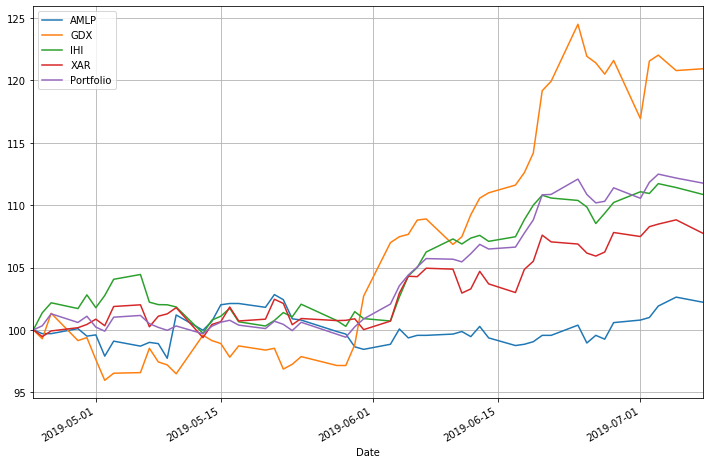

In [6]:
quote.setup_mask(stats.index)
ratio, shrp = quote.optimize_portfolio(.1)
print(ratio, shrp)
quote.setup_mask(ratio)
quote.graph(ratio)